## Simulate a stationary time series (with an AR Root near unity)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

$ARMA(2,1)$ Process: <br>
$v[k]-1.51v[k-1]+0.5238v[k-2]=e[k]+0.3e[k-1]$

In [2]:
ar = np.array([1,-1.51,0.5238])
ma = np.array([1,0.3])

In [3]:
arma_process= sm.tsa.ArmaProcess(ar, ma)

AR Polynomial:<br>
$D(z^{-1})=1-1.51z^{-1}+0.5238z^{-2}$ <br>
Root of this polynomial $(1-0.97z^{-1})(1-0.54z^{-1})=0$ is 1.0309 and 1.851 (in terms of $z^{-1}$)

In [4]:
arma_process.arroots

array([1.03092784, 1.85185185])

MA polynomial:<br>
$C(z^{-1})=1+0.3z^{-1}$.
Root of this polynomial is -3.333 (in terms of $z^{-1}$)

In [5]:
arma_process.maroots

array([-3.33333333])

Since the roots are outside the unit circle (in terms of $z^{-1}$)

In [6]:
arma_process.isstationary & arma_process.isinvertible

True

Generate a time series $v[k]$ of 500 observations

In [7]:
vk_array=arma_process.generate_sample(500)

In [8]:
vk=pd.Series(vk_array)

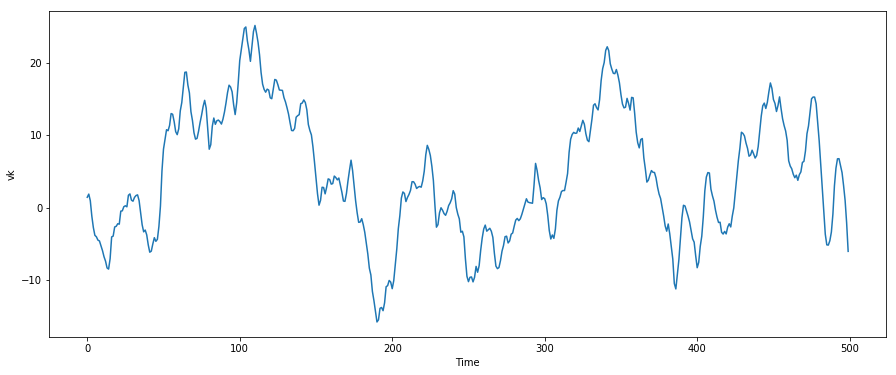

In [9]:
ylabel='vk'
xlabel='Time'
ax = vk.plot(figsize=(15,6))
ax.set(xlabel=xlabel, ylabel=ylabel);

## Time Series Modelling

Forget the process that we used to generate this time series. Assume we are given with the time series $v[k]$

In [10]:
# Step 1: Summary Statistic of vk
vk.describe()

count    500.000000
mean       4.489908
std        8.674653
min      -15.835815
25%       -2.315858
50%        3.274102
75%       11.593908
max       25.190630
dtype: float64

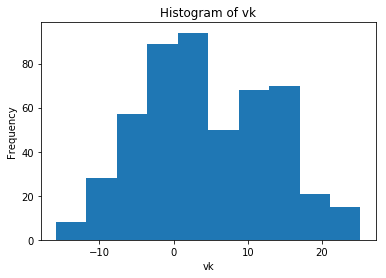

In [11]:
# Step 2: Test whether the series v[k] has fallen out of a joint Gaussian
title = 'Histogram of vk'
ylabel='Frequency'
xlabel='vk'
ax = vk.plot.hist(title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

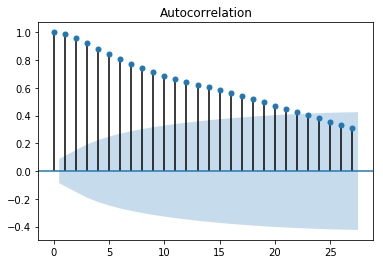

In [13]:
plot_acf(vk);

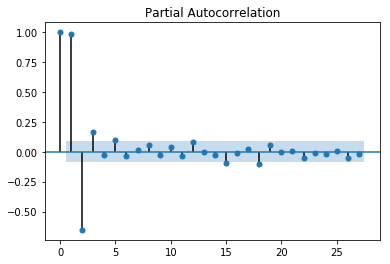

In [14]:
plot_pacf(vk);

ACF decays very slowly and PACF at lag 1 is near unity. This indicates the presence of pole at unity.<br>
But let's go with the AR(3) as suggested by PACF and see the parameter estimates.

In [20]:
# Method 1:
# Fitting an AR model using ARIMA routine
ar3mod = sm.tsa.arima.ARIMA(vk, order=(3,0,0)).fit()
print(ar3mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -702.127
Date:                Sun, 13 Jun 2021   AIC                           1414.254
Time:                        21:23:29   BIC                           1435.327
Sample:                             0   HQIC                          1422.523
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6806      2.668      1.380      0.168      -1.548       8.910
ar.L1          1.8020      0.044     40.745      0.000       1.715       1.889
ar.L2         -1.0211      0.083    -12.355      0.0

In [21]:
ar3mod.arparams

array([ 1.80196438, -1.02108299,  0.20262047])

Estimated model is:<br>
$\hat{v}[k]=1.801v[k-1]-1.0210v[k-2]+0.2026v[k-3]$ <br>

In terms of transfer function operator:<br>
$\hat{H_{1}}(q^{-1})=\frac{1}{1-1.801q^{-1}+1.021q^{-2}-0.2026q^{-3}}$

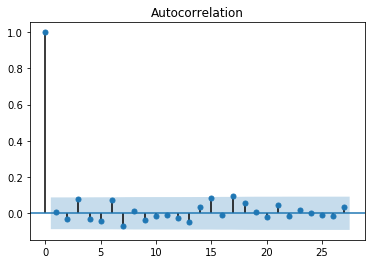

In [19]:
plot_acf(ar3mod.resid);

The model passes the residual test (Residuals are white). The errors in the parameter estimates are low and hence reliable.

## Tests for Unit Root

Method 2:
Let's test the presence of unit root using the Augmented Dickey-Fuller test.

In [25]:
from statsmodels.tsa.stattools import adfuller

In [27]:
# Null hypothesis: The series has a unit root
adfuller(vk)

(-2.892071762687184,
 0.046277741832574416,
 4,
 495,
 {'1%': -3.4436298692815304,
  '5%': -2.867396599893435,
  '10%': -2.5698893429241916},
 1354.5470073270155)

P value is high if we are looking for 99% significance level and we have no evidence to reject the Null hypothesis. This also confirms that the series is not stationary. Let's difference the series.

In [28]:
vdk = vk.diff()

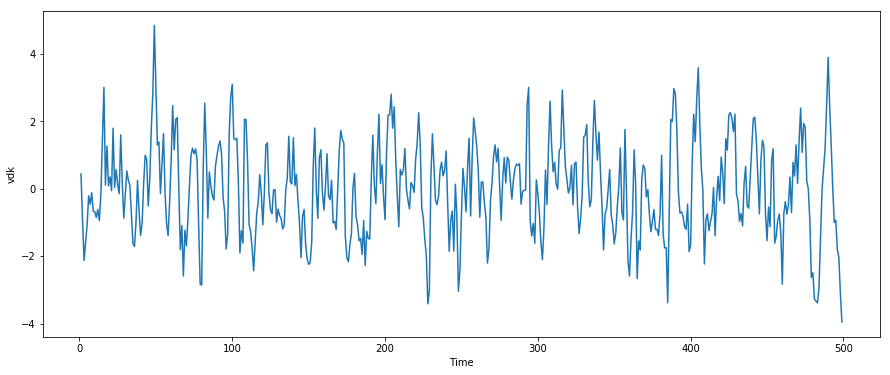

In [29]:
# Let's see the characteristics of the differenced series
ylabel='vdk'
xlabel='Time'
ax = vdk.plot(figsize=(15,6))
ax.set(xlabel=xlabel, ylabel=ylabel);

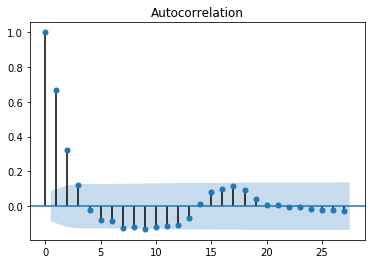

In [31]:
plot_acf(vdk[1:]);

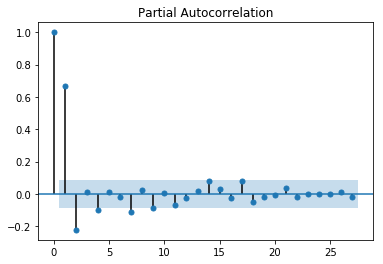

In [32]:
plot_pacf(vdk[1:]);

Now the series looks stationary as suggested by the signature of ACF and PACF. <br>
And it also suggest to fit MA(3) (from the signature of ACF) or AR(2) (from the signature of PACF).<br>
We will go with AR(2) and for comparison purposes, we fit an ARMA(1,1) model, which is also characterized by two parameters.

In [41]:
# Fitting an AR model using ARIMA routine
ar2mod = sm.tsa.arima.ARIMA(vdk[1:], order=(2,0,0)).fit()
print(ar2mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  499
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -703.646
Date:                Sun, 13 Jun 2021   AIC                           1415.291
Time:                        21:52:56   BIC                           1432.142
Sample:                             0   HQIC                          1421.904
                                - 499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.112     -0.188      0.851      -0.240       0.198
ar.L1          0.8271      0.043     19.075      0.000       0.742       0.912
ar.L2         -0.2265      0.045     -5.075      0.0

Estimated model is:
(In terms of transfer function operator) <br>
$\hat{H}(q^{-1})=\frac{1}{1-0.8271q^{-1}+0.2265q^{-2}}$

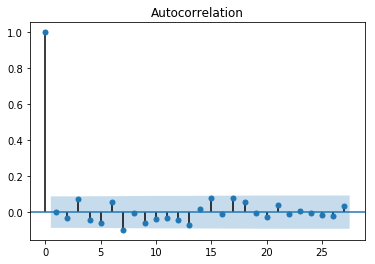

In [42]:
plot_acf(ar2mod.resid);

In [43]:
# Fitting an ARMA model using ARIMA routine
arma11mod = sm.tsa.arima.ARIMA(vdk[1:], order=(1,0,1)).fit()
print(arma11mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  499
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -703.471
Date:                Sun, 13 Jun 2021   AIC                           1414.942
Time:                        21:53:25   BIC                           1431.792
Sample:                             0   HQIC                          1421.554
                                - 499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0235      0.120     -0.196      0.845      -0.258       0.211
ar.L1          0.5046      0.050     10.102      0.000       0.407       0.603
ma.L1          0.3304      0.057      5.839      0.0

Estimated model is:
(In terms of transfer function operator) <br>
$\hat{H}(q^{-1})=\frac{1+0.3304q^{-1}}{1-0.5046q^{-1}}$

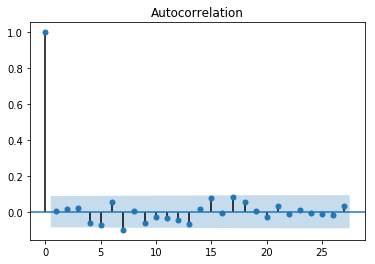

In [44]:
plot_acf(arma11mod.resid);

$ARMA(1,1)$ has done a better job of explaining the given differenced series because it has lower AIC than AR(2) model.

Thus, a suitable ARIMA model for the given series $v[k]$ is: 
(In terms of transfer function operator) <br>
$\hat{H_{2}}(q^{-1})=\frac{1+0.3304q^{-1}}{(1-q^{-1})(1-0.5046q^{-1})}$

So our model for $v[k]$ is $ARIMA(1,1,1)$ <br>
Can also be looked as an $ARMA(2,1)$ model with one of the poles fixed at unity.

# Conclusion

Now we are with 2 models: AR(3) and ARIMA(1,1,1). Which one to choose? $\hat{H_{1}}$ or $\hat{H_{2}}$ ?

In [45]:
#Let's look at the pole locations of AR(3) model:
ar3mod.arroots 
#(Roots are in terms of z^-1)

array([1.04733299-0.j        , 1.99602703-0.85332573j,
       1.99602703+0.85332573j])

In [53]:
ar3mod.arparams

array([ 1.80196438, -1.02108299,  0.20262047])

The deciding factor is the confidence region for each of those models.

In [52]:
# Std.error for 1st parameter is 0.044. When the first parameter is 1.802+(3*0.044)=1.934
arma_process_test= sm.tsa.ArmaProcess(ar=[1,-1.934,1.021,-0.2026], ma=[1])
arma_process_test.arroots

array([0.80364947+0.j        , 2.1179186 -1.28693269j,
       2.1179186 +1.28693269j])

One of the possible models in the model set of $\hat{H_{1}}$ has poles located at 0.803 (in terms of $z^{-1})$<br>
An explosive model appears in the confidence region, which is not acceptable.

Hence $\hat{H_{2}}$ is selected as the suitable model.<br>
$\hat{H_{2}}(q^{-1})=\frac{1+0.3304q^{-1}}{(1-q^{-1})(1-0.5046q^{-1})}$

Comparing with the model that we used to generate the series:<br>
$H(q^{-1})=\frac{1+0.3q^{-1}}{(1-0.97q^{-1})(1-0.54q^{-1})}$

This is great! We are very close to the truth!

Reference:<br>
Tangirala, A.K. (2015). Principles of System Identification: Theory and Practice (1st ed.). CRC Press. https://doi.org/10.1201/9781315222509